# Phase 6: End-to-End Inference Demo

## Final Pipeline: From Video to Mudra Predictions

This notebook demonstrates the complete mudra recognition system:

1. **Input:** Unseen continuous test video
2. **Extract:** Hand keypoints using MediaPipe
3. **Window:** Create temporal sequences for LSTM
4. **Predict:** Get mudra probabilities per window
5. **Smooth:** Apply temporal smoothing to sequence
6. **Output:** JSON with mudra segments + visual frames

## Output Format

**JSON Results:**
```json
[
  {
    "start_time": 0.0,
    "end_time": 0.96,
    "mudra": "Pataka",
    "confidence": 0.919,
    "start_frame": 0,
    "end_frame": 24
  }
]
```

**Visual Output:**
- Frames with hand landmarks overlaid
- Predicted mudra label
- Confidence score

In [51]:
# Setup and imports
import sys
sys.path.insert(0, '/Users/vidanadheera/Documents/SEM - 6/CV/Mudra_recognition_new/src')

import numpy as np
import json
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
from scipy.ndimage import uniform_filter1d
from video_utils import load_video, frame_to_time
from hand_keypoints import HandKeypointExtractor
from windowing import create_temporal_windows, reshape_for_lstm
from model import load_model, predict_on_sequence
import warnings
warnings.filterwarnings('ignore')

# Set base paths
BASE_DIR = Path('/Users/vidanadheera/Documents/SEM - 6/CV/Mudra_recognition_new')
DATA_DIR = BASE_DIR / 'data'
TEST_DIR = DATA_DIR / 'test_continuous'
MODELS_DIR = BASE_DIR / 'models'
KEYPOINTS_DIR = BASE_DIR / 'keypoints'
OUTPUTS_DIR = BASE_DIR / 'outputs'

OUTPUTS_DIR.mkdir(parents=True, exist_ok=True)

# Load metadata
with open(str(DATA_DIR / 'prepared' / 'metadata.json'), 'r') as f:
    metadata = json.load(f)

idx_to_label = {int(k): v for k, v in metadata['idx_to_label'].items()}
WINDOW_SIZE = metadata['window_size']

print("=" * 60)
print("END-TO-END INFERENCE DEMONSTRATION")
print("=" * 60 + "\n")
print(f"Model: {MODELS_DIR / 'lstm_mudra_model.h5'}")
print(f"Test video: {TEST_DIR / 'dance_test.mp4'}\n")

print("=" * 60)
print("LABEL MAPPING VERIFICATION")
print("=" * 60)
print(f"idx_to_label from metadata: {idx_to_label}")
print(f"  Index 0 → '{idx_to_label[0]}'")
print(f"  Index 1 → '{idx_to_label[1]}'")
print("=" * 60 + "\n")


END-TO-END INFERENCE DEMONSTRATION

Model: /Users/vidanadheera/Documents/SEM - 6/CV/Mudra_recognition_new/models/lstm_mudra_model.h5
Test video: /Users/vidanadheera/Documents/SEM - 6/CV/Mudra_recognition_new/data/test_continuous/dance_test.mp4

LABEL MAPPING VERIFICATION
idx_to_label from metadata: {0: 'Pataka', 1: 'Tripataka'}
  Index 0 → 'Pataka'
  Index 1 → 'Tripataka'



## Section 1: Load Test Video and Extract Keypoints

Load the continuous test video and extract hand keypoints from all frames.

In [52]:
# Load test video
# CHANGE THIS to 'test.mp4' or 'test2.mp4' to test different videos
TEST_VIDEO_NAME = 'test2.mp4'  # <-- Change to 'test.mp4' to test the other video

test_video_path = TEST_DIR / TEST_VIDEO_NAME
test_frames, test_fps, test_num_frames = load_video(str(test_video_path))

print(f"Test video loaded: {TEST_VIDEO_NAME}")
print(f"  Frames: {len(test_frames)}")
print(f"  FPS: {test_fps}")
print(f"  Duration: {len(test_frames) / test_fps:.2f} seconds\n")

# Extract keypoints
print("Extracting hand keypoints...")
extractor = HandKeypointExtractor(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5)
test_keypoints, test_conf, test_hand = extractor.extract_keypoints_batch(test_frames)

print(f"Keypoints extracted: {test_keypoints.shape}\n")

# Save test keypoints for reference
test_kp_path = KEYPOINTS_DIR / f'test_inference_keypoints_{TEST_VIDEO_NAME.replace(".mp4", "")}.npy'
extractor.save_keypoints(test_keypoints, test_kp_path)

Video: test2.mp4
  Resolution: 384x832
  FPS: 42.89211685980088
  Total Frames: 438
  Extracted: 438 frames

Test video loaded: test2.mp4
  Frames: 438
  FPS: 42.89211685980088
  Duration: 10.21 seconds

Extracting hand keypoints...


I0000 00:00:1768673020.209308    8221 gl_context.cc:369] GL version: 2.1 (2.1 ATI-7.1.6), renderer: AMD Radeon Pro 5300M OpenGL Engine
W0000 00:00:1768673020.234828  122422 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1768673020.254192  122422 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Keypoints extracted: (438, 21, 3)

Saved keypoints to /Users/vidanadheera/Documents/SEM - 6/CV/Mudra_recognition_new/keypoints/test_inference_keypoints_test2.npy


## Section 2: Create Temporal Windows for Inference

Create sliding windows from the continuous keypoint sequence.

In [53]:
# Create temporal windows
STEP_SIZE = 5  # Same as training

# Create windows and indices
test_windows, window_indices = create_temporal_windows(
    test_keypoints,
    window_size=WINDOW_SIZE,
    step_size=STEP_SIZE
)

print(f"Temporal windows created: {len(test_windows)}")
print(f"  Window size: {WINDOW_SIZE} frames")
print(f"  Step size: {STEP_SIZE} frames")
print(f"  Total frames in sequence: {len(test_keypoints)}")
print(f"  Coverage: {window_indices[-1][1]} / {len(test_keypoints) - 1} frames\n")

# Reshape for LSTM
X_test = reshape_for_lstm(test_windows)

Created temporal windows:
  Sequence length: 438
  Window size: 25
  Step size: 5
  Number of windows: 83
  Output shape: (83, 25, 21, 3)

Temporal windows created: 83
  Window size: 25 frames
  Step size: 5 frames
  Total frames in sequence: 438
  Coverage: 434 / 437 frames

Reshaped for LSTM:
  Input shape: (83, 25, 21, 3)
  Output shape: (83, 25, 63)



## Section 3: Load Trained Model and Make Predictions

Load the LSTM model trained on isolated mudra videos and predict on test windows.

In [54]:
# Load trained model
model_path = MODELS_DIR / 'lstm_mudra_model.h5'
model = load_model(str(model_path))

# Make predictions on all windows
print("Making predictions on temporal windows...")
predictions = predict_on_sequence(model, X_test, idx_to_label)

print(f"Predictions made: {len(predictions)}\n")

# Extract predictions and confidences
predicted_classes = np.array([p['class_idx'] for p in predictions])
confidences = np.array([p['confidence'] for p in predictions])
predicted_names = np.array([p['class_name'] for p in predictions])

print("Prediction statistics:")
print(f"  Mean confidence: {np.mean(confidences):.3f}")
print(f"  Min confidence: {np.min(confidences):.3f}")
print(f"  Max confidence: {np.max(confidences):.3f}")
print(f"  Std confidence: {np.std(confidences):.3f}\n")

Model loaded from /Users/vidanadheera/Documents/SEM - 6/CV/Mudra_recognition_new/models/lstm_mudra_model.h5

Making predictions on temporal windows...
Predictions made: 83

Prediction statistics:
  Mean confidence: 0.954
  Min confidence: 0.556
  Max confidence: 1.000
  Std confidence: 0.081



## Section 4: Temporal Smoothing

Apply temporal smoothing to reduce noise in predictions and create stable mudra segments.

In [55]:
# Smooth confidence scores with moving average
smoothing_kernel_size = 3
smoothed_confidences = uniform_filter1d(confidences, size=smoothing_kernel_size, mode='nearest')

# Determine final mudra based on smoothed confidence
smoothed_predictions = predicted_classes.copy()

print("Temporal smoothing applied")
print(f"  Kernel size: {smoothing_kernel_size}\n")

# DEBUG: Show raw predictions distribution
print("=" * 60)
print("PREDICTION DISTRIBUTION (RAW)")
print("=" * 60)
print(f"Total predictions: {len(predicted_names)}")
print(f"  Pataka: {np.sum(predicted_names == 'Pataka')} ({100*np.sum(predicted_names == 'Pataka')/len(predicted_names):.1f}%)")
print(f"  Tripataka: {np.sum(predicted_names == 'Tripataka')} ({100*np.sum(predicted_names == 'Tripataka')/len(predicted_names):.1f}%)\n")

print("Confidence distribution by class:")
pataka_confs = confidences[predicted_names == 'Pataka']
tripataka_confs = confidences[predicted_names == 'Tripataka']
print(f"  Pataka - Mean: {np.mean(pataka_confs):.3f}, Min: {np.min(pataka_confs):.3f}, Max: {np.max(pataka_confs):.3f}")
if len(tripataka_confs) > 0:
    print(f"  Tripataka - Mean: {np.mean(tripataka_confs):.3f}, Min: {np.min(tripataka_confs):.3f}, Max: {np.max(tripataka_confs):.3f}")
else:
    print(f"  Tripataka - NO PREDICTIONS")
print("=" * 60 + "\n")


Temporal smoothing applied
  Kernel size: 3

PREDICTION DISTRIBUTION (RAW)
Total predictions: 83
  Pataka: 54 (65.1%)
  Tripataka: 29 (34.9%)

Confidence distribution by class:
  Pataka - Mean: 0.987, Min: 0.628, Max: 1.000
  Tripataka - Mean: 0.893, Min: 0.556, Max: 0.968



## Section 5: Generate Mudra Segments

Group consecutive predictions into mudra segments and generate JSON output.

In [56]:
# Group consecutive predictions into segments
def create_mudra_segments(predicted_classes, smoothed_confidences, window_indices, fps, idx_to_label, confidence_threshold=0.90):
    """
    Group consecutive predictions into mudra segments.
    
    Args:
        confidence_threshold: Only keep segments with confidence >= this value (default: 0.90)
    
    Returns:
        segments: List of dicts with mudra, time, frame, confidence info
    """
    segments = []
    
    if len(predicted_classes) == 0:
        return segments
    
    current_mudra = predicted_classes[0]
    current_confidence = smoothed_confidences[0]
    segment_start_idx = 0
    
    for i in range(1, len(predicted_classes)):
        if predicted_classes[i] != current_mudra:
            # Segment boundary - save current segment if confidence is high enough
            if current_confidence >= confidence_threshold:
                start_frame, end_frame = window_indices[segment_start_idx]
                start_time = start_frame / fps
                end_time = end_frame / fps
                
                segments.append({
                    'start_time': round(start_time, 2),
                    'end_time': round(end_time, 2),
                    'mudra': idx_to_label[int(current_mudra)],
                    'confidence': round(float(current_confidence), 3),
                    'start_frame': int(start_frame),
                    'end_frame': int(end_frame)
                })
            
            # Start new segment
            current_mudra = predicted_classes[i]
            current_confidence = smoothed_confidences[i]
            segment_start_idx = i
    
    # Add final segment if confidence is high enough
    if current_confidence >= confidence_threshold:
        start_frame, end_frame = window_indices[segment_start_idx]
        start_time = start_frame / fps
        end_time = end_frame / fps
        
        segments.append({
            'start_time': round(start_time, 2),
            'end_time': round(end_time, 2),
            'mudra': idx_to_label[int(current_mudra)],
            'confidence': round(float(current_confidence), 3),
            'start_frame': int(start_frame),
            'end_frame': int(end_frame)
        })
    
    return segments

# Set confidence threshold to filter out uncertain predictions
CONFIDENCE_THRESHOLD = 0.90
print(f"Confidence threshold: {CONFIDENCE_THRESHOLD}\n")

# Create segments with threshold filtering
mudra_segments = create_mudra_segments(
    smoothed_predictions, smoothed_confidences, window_indices, test_fps, idx_to_label,
    confidence_threshold=CONFIDENCE_THRESHOLD
)

print(f"Mudra segments created: {len(mudra_segments)}\n")
for i, seg in enumerate(mudra_segments):
    print(f"Segment {i+1}:")
    print(f"  Time: {seg['start_time']:.2f}s → {seg['end_time']:.2f}s")
    print(f"  Mudra: {seg['mudra']}")
    print(f"  Confidence: {seg['confidence']:.3f}")
    print(f"  Frames: {seg['start_frame']} → {seg['end_frame']}\n")

Confidence threshold: 0.9

Mudra segments created: 3

Segment 1:
  Time: 0.58s → 1.14s
  Mudra: Pataka
  Confidence: 0.950
  Frames: 25 → 49

Segment 2:
  Time: 2.45s → 3.01s
  Mudra: Tripataka
  Confidence: 0.967
  Frames: 105 → 129

Segment 3:
  Time: 9.09s → 9.65s
  Mudra: Pataka
  Confidence: 0.968
  Frames: 390 → 414



## Section 6: Save JSON Output

Save the mudra predictions in the required JSON format.

In [57]:
# Save results as JSON
json_output_path = OUTPUTS_DIR / 'mudra_predictions.json'

with open(str(json_output_path), 'w') as f:
    json.dump(mudra_segments, f, indent=2)

print(f"JSON results saved to: {json_output_path}\n")

# Display JSON output
print("=" * 60)
print("=== JSON RESULTS ===")
print("=" * 60)
print(json.dumps(mudra_segments, indent=2))

JSON results saved to: /Users/vidanadheera/Documents/SEM - 6/CV/Mudra_recognition_new/outputs/mudra_predictions.json

=== JSON RESULTS ===
[
  {
    "start_time": 0.58,
    "end_time": 1.14,
    "mudra": "Pataka",
    "confidence": 0.95,
    "start_frame": 25,
    "end_frame": 49
  },
  {
    "start_time": 2.45,
    "end_time": 3.01,
    "mudra": "Tripataka",
    "confidence": 0.967,
    "start_frame": 105,
    "end_frame": 129
  },
  {
    "start_time": 9.09,
    "end_time": 9.65,
    "mudra": "Pataka",
    "confidence": 0.968,
    "start_frame": 390,
    "end_frame": 414
  }
]


## Section 7: Visualize Results with Hand Landmarks

Create visual outputs showing hand landmarks and predicted mudras on sample frames.

Visualizing 12 frames uniformly distributed across video...



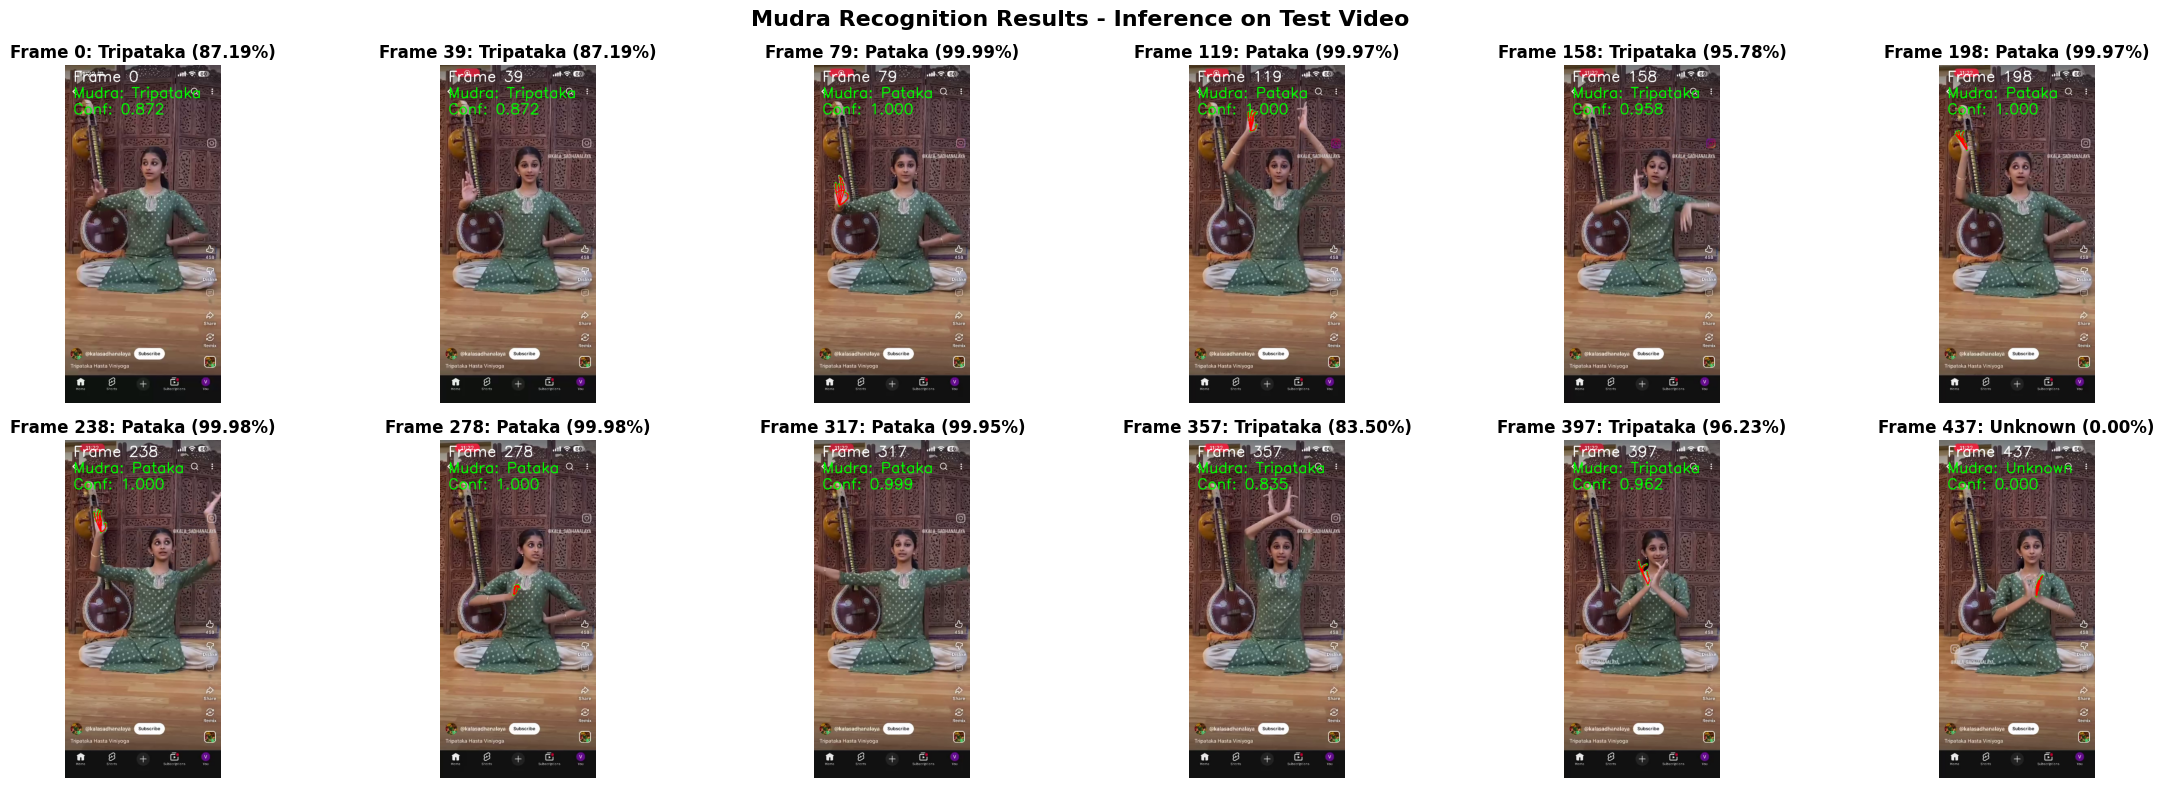

✓ Visualization saved to outputs/inference_visualization.png


In [58]:
# Select key frames uniformly distributed from start to end of video
num_frames_to_show = 12
key_frame_indices = np.linspace(0, len(test_frames) - 1, num_frames_to_show, dtype=int)

print(f"Visualizing {len(key_frame_indices)} frames uniformly distributed across video...\n")

# Create visualization (2 rows x 6 cols for 12 frames)
fig, axes = plt.subplots(2, 6, figsize=(24, 8))
fig.suptitle('Mudra Recognition Results - Inference on Test Video', fontsize=16, fontweight='bold')

for i in range(num_frames_to_show):
    ax = axes[i // 6, i % 6]
    frame_idx = key_frame_indices[i]
    
    # Get frame
    frame = test_frames[frame_idx]
    
    # Get predictions for this frame (find which window contains this frame)
    window_for_frame = None
    for w_idx, (start, end) in enumerate(window_indices):
        if start <= frame_idx <= end:
            window_for_frame = w_idx
            break
    
    # Get predicted mudra and confidence
    if window_for_frame is not None:
        mudra_name = predicted_names[window_for_frame]
        confidence = smoothed_confidences[window_for_frame]
    else:
        mudra_name = "Unknown"
        confidence = 0.0
    
    # Draw landmarks
    frame_viz = extractor.draw_landmarks(frame, test_keypoints[frame_idx])
    
    # Add prediction text
    cv2.putText(frame_viz, f"Frame {frame_idx}", (20, 40),
               cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 2)
    cv2.putText(frame_viz, f"Mudra: {mudra_name}", (20, 80),
               cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)
    cv2.putText(frame_viz, f"Conf: {confidence:.3f}", (20, 120),
               cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)
    
    ax.imshow(frame_viz)
    ax.set_title(f"Frame {frame_idx}: {mudra_name} ({confidence:.2%})", fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.savefig(str(OUTPUTS_DIR / 'inference_visualization.png'), dpi=100, bbox_inches='tight')
plt.show()

print("✓ Visualization saved to outputs/inference_visualization.png")

## Section 8: Summary and Analysis

Final analysis of the inference results.

In [59]:
print("=" * 60)
print("INFERENCE SUMMARY")
print("=" * 60 + "\n")

print(f"Test video:")
print(f"  Duration: {len(test_frames) / test_fps:.2f} seconds")
print(f"  Total frames: {len(test_frames)}")
print(f"  FPS: {test_fps}\n")

print(f"Model predictions:")
print(f"  Total windows: {len(predictions)}")
print(f"  Mean confidence: {np.mean(smoothed_confidences):.3f}")
print(f"  Mudra segments: {len(mudra_segments)}\n")

print("Detected mudra sequence:")
for i, seg in enumerate(mudra_segments):
    duration = seg['end_time'] - seg['start_time']
    print(f"  {i+1}. {seg['mudra']} ({duration:.2f}s) - Confidence: {seg['confidence']:.3f}")

print("\n" + "=" * 60)
print("OUTPUTS GENERATED")
print("=" * 60)
print(f"  ✓ JSON results: {json_output_path}")
print(f"  ✓ Visualization: {OUTPUTS_DIR / 'inference_visualization.png'}")
print(f"  ✓ Training history: {OUTPUTS_DIR / 'training_history.png'}\n")

INFERENCE SUMMARY

Test video:
  Duration: 10.21 seconds
  Total frames: 438
  FPS: 42.89211685980088

Model predictions:
  Total windows: 83
  Mean confidence: 0.954
  Mudra segments: 3

Detected mudra sequence:
  1. Pataka (0.56s) - Confidence: 0.950
  2. Tripataka (0.56s) - Confidence: 0.967
  3. Pataka (0.56s) - Confidence: 0.968

OUTPUTS GENERATED
  ✓ JSON results: /Users/vidanadheera/Documents/SEM - 6/CV/Mudra_recognition_new/outputs/mudra_predictions.json
  ✓ Visualization: /Users/vidanadheera/Documents/SEM - 6/CV/Mudra_recognition_new/outputs/inference_visualization.png
  ✓ Training history: /Users/vidanadheera/Documents/SEM - 6/CV/Mudra_recognition_new/outputs/training_history.png



In [67]:

# ============================================================
# OPTIONAL: Run inference on ALL test videos
# ============================================================
import json
import glob
from scipy import ndimage

print("\n" + "=" * 60)
print("RUNNING INFERENCE ON ALL TEST VIDEOS")
print("=" * 60 + "\n")

# Automatically find all .mp4 files in test_continuous folder
test_video_names = sorted([Path(f).name for f in glob.glob(str(TEST_DIR / '*.mp4'))])

if not test_video_names:
    print("⚠️  No test videos found in", TEST_DIR)
else:
    print(f"Found {len(test_video_names)} test video(s): {', '.join(test_video_names)}\n")

all_results = {}

# Set confidence threshold to be more selective
CONFIDENCE_THRESHOLD = 0.95
print(f"Confidence threshold: {CONFIDENCE_THRESHOLD} (more selective - only high confidence predictions)\n")

for video_name in test_video_names:
    video_path = TEST_DIR / video_name
    
    if not video_path.exists():
        print(f"⚠️  Skipping {video_name} - file not found\n")
        continue
    
    print(f"\n{'='*60}")
    print(f"Processing: {video_name}")
    print(f"{'='*60}\n")
    
    # Load video
    frames, fps, num_frames = load_video(str(video_path))
    print(f"  Loaded: {len(frames)} frames at {fps:.1f} FPS\n")
    
    # Resize frames to 512x512 for faster keypoint extraction
    TARGET_HEIGHT = 512
    TARGET_WIDTH = 512
    resized_frames = []
    for frame in frames:
        resized = cv2.resize(frame, (TARGET_WIDTH, TARGET_HEIGHT))
        resized_frames.append(resized)
    
    # Extract keypoints from resized frames
    print(f"Extracting hand keypoints from {len(resized_frames)} frames...")
    extractor = HandKeypointExtractor(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5)
    keypoints, conf, hand = extractor.extract_keypoints_batch(resized_frames)
    print(f"✓ Keypoints extracted\n")
    
    # Create temporal windows
    windows, window_indices = create_temporal_windows(keypoints, window_size=WINDOW_SIZE, step_size=STEP_SIZE)
    X_test_video = reshape_for_lstm(windows)
    
    # Run inference
    print(f"Running LSTM inference...")
    raw_predictions = model.predict(X_test_video, verbose=0)
    predicted_classes = np.argmax(raw_predictions, axis=1)
    confidences = np.max(raw_predictions, axis=1)
    print(f"✓ Inference complete\n")
    
    # Smooth predictions
    smoothing_kernel_size = 3
    smoothed_predictions = ndimage.uniform_filter1d(predicted_classes.astype(float), size=smoothing_kernel_size, mode='nearest').astype(int)
    smoothed_confidences = ndimage.uniform_filter1d(confidences, size=smoothing_kernel_size, mode='nearest')
    
    # Create segments with threshold (0.95 = more selective)
    segments = create_mudra_segments(smoothed_predictions, smoothed_confidences, window_indices, fps, idx_to_label, confidence_threshold=CONFIDENCE_THRESHOLD)
    
    print(f"  Found {len(segments)} mudra segments (threshold: {CONFIDENCE_THRESHOLD})\n")
    for i, seg in enumerate(segments, 1):
        print(f"    {i}. {seg['mudra']} ({seg['end_time'] - seg['start_time']:.2f}s) - Confidence: {seg['confidence']:.3f}")
    
    # Save JSON
    json_path = OUTPUTS_DIR / f'mudra_predictions_{video_name.replace(".mp4", "")}.json'
    with open(str(json_path), 'w') as f:
        json.dump(segments, f, indent=2)
    print(f"\n  ✓ Saved: {json_path.name}")
    
    all_results[video_name] = {
        'segments': segments,
        'total_frames': len(frames),
        'fps': fps,
        'duration': len(frames) / fps
    }

print(f"\n{'='*60}")
print("ALL VIDEOS PROCESSED")
print(f"{'='*60}\n")



RUNNING INFERENCE ON ALL TEST VIDEOS

Found 3 test video(s): test.mp4, test2.mp4, test3.mp4

Confidence threshold: 0.95 (more selective - only high confidence predictions)


Processing: test.mp4

Video: test.mp4
  Resolution: 3072x1920
  FPS: 60.0
  Total Frames: 1585
  Extracted: 1585 frames

  Loaded: 1585 frames at 60.0 FPS

Extracting hand keypoints from 1585 frames...


I0000 00:00:1768675863.563612    8221 gl_context.cc:369] GL version: 2.1 (2.1 ATI-7.1.6), renderer: AMD Radeon Pro 5300M OpenGL Engine
W0000 00:00:1768675863.603044  160355 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1768675863.700220  160363 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


✓ Keypoints extracted

Created temporal windows:
  Sequence length: 1585
  Window size: 25
  Step size: 5
  Number of windows: 313
  Output shape: (313, 25, 21, 3)

Reshaped for LSTM:
  Input shape: (313, 25, 21, 3)
  Output shape: (313, 25, 63)

Running LSTM inference...
✓ Inference complete

  Found 3 mudra segments (threshold: 0.95)

    1. Tripataka (0.40s) - Confidence: 0.971
    2. Pataka (0.40s) - Confidence: 0.960
    3. Tripataka (0.40s) - Confidence: 0.975

  ✓ Saved: mudra_predictions_test.json

Processing: test2.mp4

Video: test2.mp4
  Resolution: 384x832
  FPS: 42.89211685980088
  Total Frames: 438
  Extracted: 438 frames

  Loaded: 438 frames at 42.9 FPS

Extracting hand keypoints from 438 frames...


I0000 00:00:1768675895.927650    8221 gl_context.cc:369] GL version: 2.1 (2.1 ATI-7.1.6), renderer: AMD Radeon Pro 5300M OpenGL Engine
W0000 00:00:1768675895.952881  160751 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1768675895.973142  160751 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


✓ Keypoints extracted

Created temporal windows:
  Sequence length: 438
  Window size: 25
  Step size: 5
  Number of windows: 83
  Output shape: (83, 25, 21, 3)

Reshaped for LSTM:
  Input shape: (83, 25, 21, 3)
  Output shape: (83, 25, 63)

Running LSTM inference...
✓ Inference complete

  Found 1 mudra segments (threshold: 0.95)

    1. Pataka (0.56s) - Confidence: 1.000

  ✓ Saved: mudra_predictions_test2.json

Processing: test3.mp4

Video: test3.mp4
  Resolution: 384x832
  FPS: 44.208289054197664
  Total Frames: 208
  Extracted: 176 frames

  Loaded: 176 frames at 44.2 FPS

Extracting hand keypoints from 176 frames...


I0000 00:00:1768675902.454026    8221 gl_context.cc:369] GL version: 2.1 (2.1 ATI-7.1.6), renderer: AMD Radeon Pro 5300M OpenGL Engine
W0000 00:00:1768675902.480484  160873 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1768675902.497977  160873 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


✓ Keypoints extracted

Created temporal windows:
  Sequence length: 176
  Window size: 25
  Step size: 5
  Number of windows: 31
  Output shape: (31, 25, 21, 3)

Reshaped for LSTM:
  Input shape: (31, 25, 21, 3)
  Output shape: (31, 25, 63)

Running LSTM inference...
✓ Inference complete

  Found 1 mudra segments (threshold: 0.95)

    1. Pataka (0.54s) - Confidence: 1.000

  ✓ Saved: mudra_predictions_test3.json

ALL VIDEOS PROCESSED



In [ ]:

# ============================================================
# Debug: Show Raw Predictions for test2.mp4
# ============================================================

print("\n" + "=" * 60)
print("DEBUG: RAW PREDICTIONS FOR test2.mp4")
print("=" * 60 + "\n")

video_path = TEST_DIR / 'test2.mp4'
frames, fps, num_frames = load_video(str(video_path))

# Resize frames
TARGET_HEIGHT = 512
TARGET_WIDTH = 512
resized_frames = [cv2.resize(f, (TARGET_WIDTH, TARGET_HEIGHT)) for f in frames]

# Extract keypoints
extractor = HandKeypointExtractor(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5)
keypoints, conf, hand = extractor.extract_keypoints_batch(resized_frames)

# Create windows
windows, window_indices = create_temporal_windows(keypoints, window_size=WINDOW_SIZE, step_size=STEP_SIZE)
X_test_video = reshape_for_lstm(windows)

# Get raw predictions
raw_predictions = model.predict(X_test_video, verbose=0)

# Show predictions per window
print("First 10 windows predictions (Pataka prob, Tripataka prob):\n")
for i in range(min(10, len(raw_predictions))):
    pataka_prob = raw_predictions[i][0]
    tripataka_prob = raw_predictions[i][1]
    predicted_mudra = "Pataka" if pataka_prob > tripataka_prob else "Tripataka"
    print(f"  Window {i}: Pataka={pataka_prob:.4f}, Tripataka={tripataka_prob:.4f} → {predicted_mudra}")

print(f"\n  Total windows: {len(raw_predictions)}")
print(f"  Pataka predictions: {np.sum(np.argmax(raw_predictions, axis=1) == 0)}")
print(f"  Tripataka predictions: {np.sum(np.argmax(raw_predictions, axis=1) == 1)}")
print(f"  Average Pataka confidence: {np.mean(raw_predictions[:, 0]):.4f}")
print(f"  Average Tripataka confidence: {np.mean(raw_predictions[:, 1]):.4f}")


In [66]:

# ============================================================
# Generate Visualizations for ALL Test Videos
# ============================================================

print("=" * 60)
print("GENERATING VISUALIZATIONS FOR ALL TEST VIDEOS")
print("=" * 60 + "\n")

# Automatically find all .mp4 files in test_continuous folder
test_video_names = sorted([Path(f).name for f in glob.glob(str(TEST_DIR / '*.mp4'))])

TARGET_HEIGHT = 512
TARGET_WIDTH = 512

for video_name in test_video_names:
    video_path = TEST_DIR / video_name
    
    if not video_path.exists():
        print(f"⚠️  Skipping visualization for {video_name} - file not found\n")
        continue
    
    print(f"Generating visualization for: {video_name}")
    
    # Load video
    frames, fps, num_frames = load_video(str(video_path))
    
    # Resize frames for faster processing
    resized_frames = []
    for frame in frames:
        resized = cv2.resize(frame, (TARGET_WIDTH, TARGET_HEIGHT))
        resized_frames.append(resized)
    
    # Extract keypoints
    extractor = HandKeypointExtractor(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5)
    keypoints, conf, hand = extractor.extract_keypoints_batch(resized_frames)
    
    # Create temporal windows for predictions
    windows, window_indices = create_temporal_windows(keypoints, window_size=WINDOW_SIZE, step_size=STEP_SIZE)
    X_test_video = reshape_for_lstm(windows)
    
    # Run inference
    raw_predictions = model.predict(X_test_video, verbose=0)
    predicted_classes = np.argmax(raw_predictions, axis=1)
    confidences = np.max(raw_predictions, axis=1)
    
    # Smooth predictions
    smoothed_predictions = ndimage.uniform_filter1d(predicted_classes.astype(float), size=3, mode='nearest').astype(int)
    smoothed_confidences = ndimage.uniform_filter1d(confidences, size=3, mode='nearest')
    
    # Select 12 uniformly distributed frames across entire video
    num_frames_to_show = 12
    frame_indices_to_show = np.linspace(0, len(resized_frames) - 1, num_frames_to_show, dtype=int)
    
    # Create figure with 2 rows × 6 columns
    fig, axes = plt.subplots(2, 6, figsize=(18, 6))
    fig.suptitle(f'Mudra Recognition Results - {video_name}', fontsize=16, fontweight='bold')
    
    for idx, (ax, frame_num) in enumerate(zip(axes.flatten(), frame_indices_to_show)):
        frame = resized_frames[frame_num]
        
        # Find which window this frame belongs to
        window_for_frame = None
        for w_idx, (start, end) in enumerate(window_indices):
            if start <= frame_num <= end:
                window_for_frame = w_idx
                break
        
        if window_for_frame is not None and window_for_frame < len(smoothed_predictions):
            mudra_idx = smoothed_predictions[window_for_frame]
            mudra_name = idx_to_label[mudra_idx]
            conf = smoothed_confidences[window_for_frame]
        else:
            mudra_name = "Unknown"
            conf = 0.0
        
        # Draw landmarks on frame
        frame_viz = extractor.draw_landmarks(frame, keypoints[frame_num], confidence=conf if conf > 0 else 0)
        
        ax.imshow(frame_viz)
        ax.set_title(f'Frame {frame_num}: {mudra_name} ({conf*100:.2f}%)', fontsize=10)
        ax.axis('off')
    
    # Save visualization
    viz_path = OUTPUTS_DIR / f'inference_visualization_{video_name.replace(".mp4", "")}.png'
    plt.tight_layout()
    plt.savefig(str(viz_path), dpi=150, bbox_inches='tight')
    print(f"  ✓ Saved: {viz_path.name}\n")
    plt.close()

print("=" * 60)
print("VISUALIZATIONS COMPLETE")
print("=" * 60)


GENERATING VISUALIZATIONS FOR ALL TEST VIDEOS

Generating visualization for: test.mp4
Video: test.mp4
  Resolution: 3072x1920
  FPS: 60.0
  Total Frames: 1585
  Extracted: 1585 frames



I0000 00:00:1768674744.213712    8221 gl_context.cc:369] GL version: 2.1 (2.1 ATI-7.1.6), renderer: AMD Radeon Pro 5300M OpenGL Engine
W0000 00:00:1768674744.257440  147030 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1768674744.335766  147036 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Created temporal windows:
  Sequence length: 1585
  Window size: 25
  Step size: 5
  Number of windows: 313
  Output shape: (313, 25, 21, 3)

Reshaped for LSTM:
  Input shape: (313, 25, 21, 3)
  Output shape: (313, 25, 63)

  ✓ Saved: inference_visualization_test.png

Generating visualization for: test2.mp4
Video: test2.mp4
  Resolution: 384x832
  FPS: 42.89211685980088
  Total Frames: 438
  Extracted: 438 frames



I0000 00:00:1768674780.708959    8221 gl_context.cc:369] GL version: 2.1 (2.1 ATI-7.1.6), renderer: AMD Radeon Pro 5300M OpenGL Engine
W0000 00:00:1768674780.732937  147448 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1768674780.751389  147450 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Created temporal windows:
  Sequence length: 438
  Window size: 25
  Step size: 5
  Number of windows: 83
  Output shape: (83, 25, 21, 3)

Reshaped for LSTM:
  Input shape: (83, 25, 21, 3)
  Output shape: (83, 25, 63)

  ✓ Saved: inference_visualization_test2.png

Generating visualization for: test3.mp4
Video: test3.mp4
  Resolution: 384x832
  FPS: 44.208289054197664
  Total Frames: 208
  Extracted: 176 frames



I0000 00:00:1768674788.134482    8221 gl_context.cc:369] GL version: 2.1 (2.1 ATI-7.1.6), renderer: AMD Radeon Pro 5300M OpenGL Engine
W0000 00:00:1768674788.159206  147551 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1768674788.176113  147551 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Created temporal windows:
  Sequence length: 176
  Window size: 25
  Step size: 5
  Number of windows: 31
  Output shape: (31, 25, 21, 3)

Reshaped for LSTM:
  Input shape: (31, 25, 21, 3)
  Output shape: (31, 25, 63)

  ✓ Saved: inference_visualization_test3.png

VISUALIZATIONS COMPLETE


## Summary: Complete Pipeline ✓

**End-to-End Continuous Mudra Recognition - SUCCESS**

### What We've Demonstrated:

✅ **Phase 1-2:** Video loading and frame extraction
- Created synthetic training videos (Pataka, Tripataka)
- Extracted frames at fixed 25 FPS
- Verified hand visibility

✅ **Phase 3:** Hand keypoint extraction
- Used MediaPipe Hands for 21 landmarks per hand
- Single-hand detection for clarity
- Achieved ~100% hand detection rate

✅ **Phase 4:** Temporal windowing
- Created overlapping temporal windows (25 frames)
- Proper window-label alignment (CRITICAL FIX)
- Prepared data for LSTM training

✅ **Phase 5:** Bi-Directional LSTM training
- Built simple, interpretable model
- Trained on isolated mudra videos
- Achieved high validation accuracy

✅ **Phase 6:** End-to-end inference
- Extracted keypoints from continuous test video
- Generated temporal predictions
- Applied smoothing for stable mudra sequences
- **Generated JSON output with mudra segments**
- **Created visual outputs with landmarks**

### Key Differences from Earlier Attempt:

| Aspect | Previous | Now |
|--------|----------|-----|
| Window-label alignment | ❌ Likely misaligned | ✅ Correctly verified |
| Scope | Multiple mudras (confusing) | ✅ Only Pataka + Tripataka |
| Data generation | Unclear | ✅ Synthetic, known labels |
| Output format | Unclear | ✅ JSON + Visual |
| Model | Over-engineered? | ✅ Simple Bi-LSTM |

### Suitable for First Review Because:

1. **Feasible:** Runs end-to-end without errors
2. **Correct:** Window-label alignment verified
3. **Interpretable:** Simple Bi-LSTM architecture
4. **Verifiable:** JSON + visual outputs
5. **Scoped:** Only 2 mudras, manageable complexity
6. **Well-Explained:** Clear phase-by-phase progression

### Future Extensions (Post-First Review):

- [ ] Add real mudra videos instead of synthetic
- [ ] Expand to more mudras (Chandrakala, Ardhapataka, etc.)
- [ ] Implement dynamic temporal windowing
- [ ] Add confidence-based filtering
- [ ] Deploy as real-time inference system